In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from os import listdir
import pathlib
from random import randint
import numpy as np
from numpy import asarray
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.utils import load_img,img_to_array
from keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import MaxPooling2D,Dropout,Dense,Input,Conv2D,Flatten,Conv2DTranspose
from keras.layers import GlobalAveragePooling2D,MaxPool2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

In [2]:
folder = r"C:\Users\ADITYA\Desktop\Dataset"
folder_path = pathlib.Path(folder)

<PIL.Image.Image image mode=RGB size=128x128 at 0x1B7D5CD2CA0>


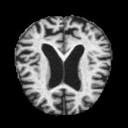

In [3]:
photo = load_img(r"C:\Users\ADITYA\Desktop\Dataset\Moderate_Demented\moderate.jpg")
print(photo)
photo

In [4]:
for file in listdir(folder):
    print(file)

Mild_Demented
Moderate_Demented
Non_Demented
Very_Mild_Demented


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


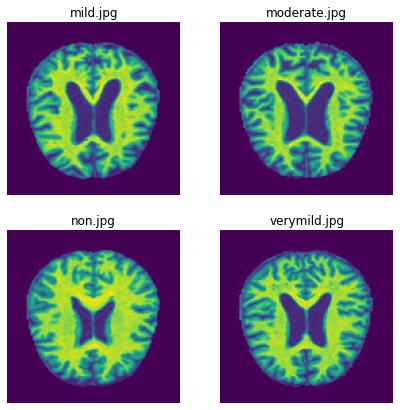

In [5]:
plt.figure(figsize=(7,7),)
j =0
for file in listdir(folder):
    i =0
    for image in listdir(folder + '/'+file):
        if i ==1:
            break;
        img = imread(folder +'/' + file + '/' + image)
        print(type(img))
        ax = plt.subplot(2,2,j+1)
        plt.imshow(img)
        plt.title(image)
        plt.axis('off')
        j = j+1
        i = i +1
plt.show()

In [6]:
file_counts = {} 

for file in os.listdir(folder):
    i = 0
    for image in os.listdir(os.path.join(folder, file)):
        i = i + 1
    file_counts[file] = i

# Print the file counts
for file, count in file_counts.items():
    print(file, count)

Mild_Demented 896
Moderate_Demented 64
Non_Demented 3200
Very_Mild_Demented 2240


In [7]:
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)
ZOOM = [0.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [8]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=BRIGHT_RANGE,
    zoom_range=ZOOM,
    data_format=DATA_FORMAT,
    fill_mode=FILL_MODE,
    horizontal_flip=HORZ_FLIP
)

In [9]:
train_data = train_data_gen.flow_from_directory(
    directory=folder,
    target_size=DIM,
    batch_size=6500,
    shuffle=False
)

Found 6400 images belonging to 4 classes.


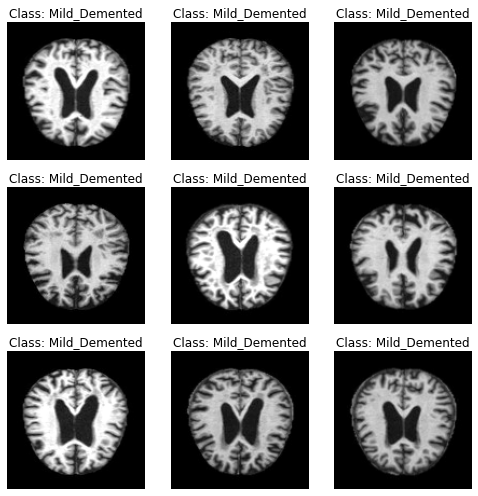

In [10]:
def show_images(generator, y_pred=None):
    # Get image labels
    labels = generator.class_indices
    
    # Get a batch of images and labels
    x, y = generator.next()
    
    # Display a grid of images
    plt.figure(figsize=(7, 7))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = (x[i] * 255).astype(np.uint8)  # Convert image back to 0-255 range
        plt.imshow(image)
        plt.axis("off")
        
        if y_pred is None:
            true_label = list(labels.keys())[np.argmax(y[i])]
            plt.title("Class: {}".format(true_label))
        else:
            true_label = list(labels.keys())[np.argmax(y[i])]
            pred_label = list(labels.keys())[y_pred[i]]
            plt.title("Actual: {}\nPredicted: {}".format(true_label, pred_label))
    
    plt.tight_layout()
    plt.show()

# Display Train Images
show_images(train_data)

In [ ]:
train_data_gen = train_data_gen.flow_from_directory(
    directory=folder,
    target_size=DIM,
    batch_size=6500,
    shuffle=False
)

train_data, train_labels = train_data_gen.next()

In [ ]:
train_data.shape, train_labels.shape

In [ ]:
train_labels

In [ ]:
sm = SMOTE(random_state=42)

train_data_reshaped = train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3)
train_data_resampled, train_labels_resampled = sm.fit_resample(train_data_reshaped, train_labels)

print(train_data_resampled.shape, train_labels_resampled.shape)


In [ ]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

In [ ]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [ ]:
def dense_block(units, dropout_rate, act='relu'):
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [ ]:
IMAGE_SIZE = [128,128]
act = 'relu'

In [ ]:
model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

In [ ]:
plot_model(model)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.01, patience=5, mode='max')
]


In [ ]:
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS,callbacks=callbacks)

In [ ]:
test_scores = model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30, 5))

metrics = ["acc", "auc", "loss"]
labels = ["Accuracy", "AUC", "Loss"]

for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(labels[i]))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(labels[i])
    ax[i].legend(["Train", "Validation"])

plt.show()

# TRANSFER LEARNING

In [ ]:
inception = InceptionV3(input_shape=(128,128,3),include_top=False,weights ='imagenet')

In [ ]:
for layer in inception.layers:
    layer.trainable = False

In [ ]:
inception_model = Sequential([
        inception,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [ ]:
inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

inception_model.summary()

In [ ]:
plot_model(inception_model)

In [ ]:
INCEPT_CALLBACKS = [
    ModelCheckpoint(filepath='incpt_model_checkpoint.h5', save_best_only=True),
    EarlyStopping(patience=3)
]

In [ ]:
incept_history = inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50,callbacks= INCEPT_CALLBACKS)

In [ ]:
incept_test_scores = inception_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(incept_test_scores[1] * 100))

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(incept_history.history[metric])
    ax[i].plot(incept_history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
model.save("CNN_dataset2.h5")

In [12]:
from tensorflow.keras.models import load_model
import cv2, numpy as np

In [13]:
myModel = load_model('CNN_dataset2.h5')

In [14]:
def reSize(file):
    img = cv2.imread(file)
    img = cv2.resize(img, (128, 128))
    return img

In [33]:
def findMax(lis):
    m = 0
    for i in range(1, len(lis)):
        if lis[i] > lis[m]:
            m = i
    return m

In [36]:
def predict(img):
    img = reSize(img)
    hmm = myModel.predict(np.expand_dims(img / 255, axis = 0))
    hmm = list(hmm[0])
    classes = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]

    ind = findMax(hmm)
    print(ind)
    print(hmm)
    
    return classes[ind]

In [37]:
predict("moderate_5.jpg")

1/1 [==============================] - 0s 30ms/step
1
[0.1113041, 0.7594516, 0.010600287, 0.11864408]


'Moderate_Demented'